C:\Users\iwtlf\AppData\Local\Temp\ipykernel_12500\1032848976.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, interval='1d')['Close']
[*********************100%***********************]  5 of 5 completed
C:\Users\iwtlf\AppData\Local\Temp\ipykernel_12500\1032848976.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf_data = yf.download(ticker, start=start_date, interval='1d')
[*********************100%***********************]  1 of 1 completed


--- Optimal Portfolio (found with SciPy) ---
Annualized Return: 18.89%
Annualized Volatility: 15.56%
Sharpe Ratio: 1.04

Average Risk-Free Rate for the period: 2.64%

Optimal Weights:
     Weight
MSFT  0.00%
JNJ  64.79%
PG    0.00%
AGG  35.21%
GLD   0.00%


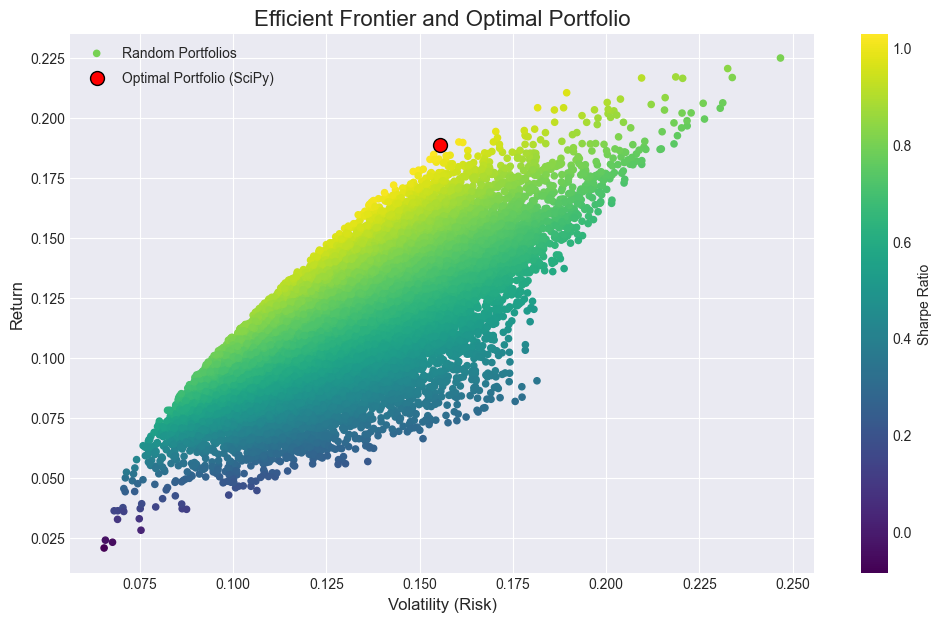

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- 1. SETTINGS ---
tickers = ['MSFT', 'JNJ', 'PG', 'AGG', 'GLD']
benchmark = '^GSPC'
risk_free_rate_ticker = '^IRX'
start_date = '2020-01-01'
num_portfolios = 25000

# --- 2. DATA LOADING (CORRECTED LOGIC) ---
def get_asset_returns(tickers, start_date):
    """Downloads data and calculates returns for the main assets."""
    data = yf.download(tickers, start=start_date, interval='1d')['Close']
    data.ffill(inplace=True)
    returns = data.pct_change().dropna()
    return returns

def get_risk_free_rate(ticker, start_date):
    """Downloads and correctly calculates the risk-free rate, returning a SINGLE number."""
    # Download data
    rf_data = yf.download(ticker, start=start_date, interval='1d')
    
    # .item() at the end extracts the single value from the object,
    # ensuring it is a simple number (float) and not a Series.
    risk_free_rate = (rf_data['Close'] / 100).mean().item()
    
    return risk_free_rate

# Load asset data
returns = get_asset_returns(tickers, start_date)
# Load and calculate the annualized risk-free rate
risk_free_rate = get_risk_free_rate(risk_free_rate_ticker, start_date)

# --- 3. OPTIMIZATION FUNCTIONS (no changes) ---
def portfolio_performance(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, returns, cov_matrix, risk_free_rate)[2]

# --- 4. OPTIMIZATION WITH SciPy (no changes) ---
cov_matrix_annual = returns.cov() * 252
num_assets = len(tickers)
bounds = tuple((0, 1) for asset in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
initial_weights = num_assets * [1. / num_assets,]

optimizer_results = minimize(negative_sharpe_ratio, initial_weights, 
                             args=(returns, cov_matrix_annual, risk_free_rate), 
                             method='SLSQP', bounds=bounds, constraints=constraints)

scipy_optimal_weights = optimizer_results.x

# --- 5. DISPLAY OPTIMIZATION RESULTS (no changes) ---
print("--- Optimal Portfolio (found with SciPy) ---")
optimal_return, optimal_volatility, optimal_sharpe = portfolio_performance(scipy_optimal_weights, returns, cov_matrix_annual, risk_free_rate)
print(f"Annualized Return: {optimal_return:.2%}")
print(f"Annualized Volatility: {optimal_volatility:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}\n")
print(f"Average Risk-Free Rate for the period: {risk_free_rate:.2%}\n")

print("Optimal Weights:")
optimal_weights_df = pd.DataFrame(scipy_optimal_weights, index=tickers, columns=['Weight'])
print(optimal_weights_df.to_string(formatters={'Weight': '{:,.2%}'.format}))

# --- 6. VISUALIZATION (no changes) ---
# This part is kept to plot the "cloud" of random portfolios for illustrative purposes
portfolio_results_mc = []
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    ret, vol, shp = portfolio_performance(weights, returns, cov_matrix_annual, risk_free_rate)
    portfolio_results_mc.append([ret, vol, shp, weights])

results_df_mc = pd.DataFrame(portfolio_results_mc, columns=['Return', 'Volatility', 'Sharpe', 'Weights'])

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 7))
scatter = plt.scatter(results_df_mc['Volatility'], results_df_mc['Return'], c=results_df_mc['Sharpe'], cmap='viridis', s=20, label='Random Portfolios')
plt.colorbar(scatter, label='Sharpe Ratio')

plt.scatter(optimal_volatility, optimal_return, c='red', s=100, edgecolors='black', label='Optimal Portfolio (SciPy)')

plt.title('Efficient Frontier and Optimal Portfolio', fontsize=16)
plt.xlabel('Volatility (Risk)', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.legend(labelspacing=0.8)
plt.savefig('v2_result.png')
plt.show()